In [73]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [74]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


In [75]:
sagemaker_session = sagemaker.Session()

In [76]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-electricity-demo-notebook"  # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [77]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [78]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [79]:
DATA_HOST = "sagemaker-sample-files"
DATA_PATH = "datasets/timeseries/uci_electricity/"
ARCHIVE_NAME = "LD2011_2014.txt.zip"
FILE_NAME = ARCHIVE_NAME[:-4]

In [80]:
s3_client = boto3.client("s3")

if not os.path.isfile(FILE_NAME):
    print("downloading dataset (258MB), can take a few minutes depending on your connection")
    s3_client.download_file(DATA_HOST, DATA_PATH + ARCHIVE_NAME, ARCHIVE_NAME)

    print("\nextracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_NAME, "r")
    zip_ref.extractall("./")
    zip_ref.close()
else:
    print("File found skipping download")

File found skipping download


In [81]:
data = pd.read_csv(FILE_NAME, sep=";", index_col=0, parse_dates=True, decimal=",")
num_timeseries = data.shape[1]
data_kw = data.resample("2H").sum() / 8
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

In [97]:
data_kw.shape

(17533, 370)

In [82]:
num_timeseries

370

In [103]:
data

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [89]:
print(timeseries)

[2012-01-01 00:00:00    3.648477
2012-01-01 02:00:00    4.600254
2012-01-01 04:00:00    4.600254
2012-01-01 06:00:00    4.441624
2012-01-01 08:00:00    2.538071
                         ...   
2014-12-31 16:00:00    2.379442
2014-12-31 18:00:00    2.220812
2014-12-31 20:00:00    2.379442
2014-12-31 22:00:00    2.062183
2015-01-01 00:00:00    0.317259
Freq: 2H, Name: MT_001, Length: 13153, dtype: float64, 2012-01-01 00:00:00    19.825747
2012-01-01 02:00:00    22.848506
2012-01-01 04:00:00    21.959459
2012-01-01 06:00:00    22.137269
2012-01-01 08:00:00    22.581792
                         ...    
2014-12-31 16:00:00    28.538407
2014-12-31 18:00:00    28.449502
2014-12-31 20:00:00    24.004267
2014-12-31 22:00:00    21.692745
2015-01-01 00:00:00     2.489331
Freq: 2H, Name: MT_002, Length: 13153, dtype: float64, 2012-01-01 00:00:00    67.658558
2012-01-01 02:00:00    77.324066
2012-01-01 04:00:00    61.794092
2012-01-01 06:00:00    17.919201
2012-01-01 08:00:00     1.629018
         

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


In [90]:
data

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [87]:
data_kw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17533 entries, 2011-01-01 00:00:00 to 2015-01-01 00:00:00
Freq: 2H
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 49.6 MB


In [53]:
#data_kw.head()

In [91]:
type(timeseries)

list

In [95]:
timeseries[0]

2012-01-01 00:00:00    3.648477
2012-01-01 02:00:00    4.600254
2012-01-01 04:00:00    4.600254
2012-01-01 06:00:00    4.441624
2012-01-01 08:00:00    2.538071
                         ...   
2014-12-31 16:00:00    2.379442
2014-12-31 18:00:00    2.220812
2014-12-31 20:00:00    2.379442
2014-12-31 22:00:00    2.062183
2015-01-01 00:00:00    0.317259
Freq: 2H, Name: MT_001, Length: 13153, dtype: float64

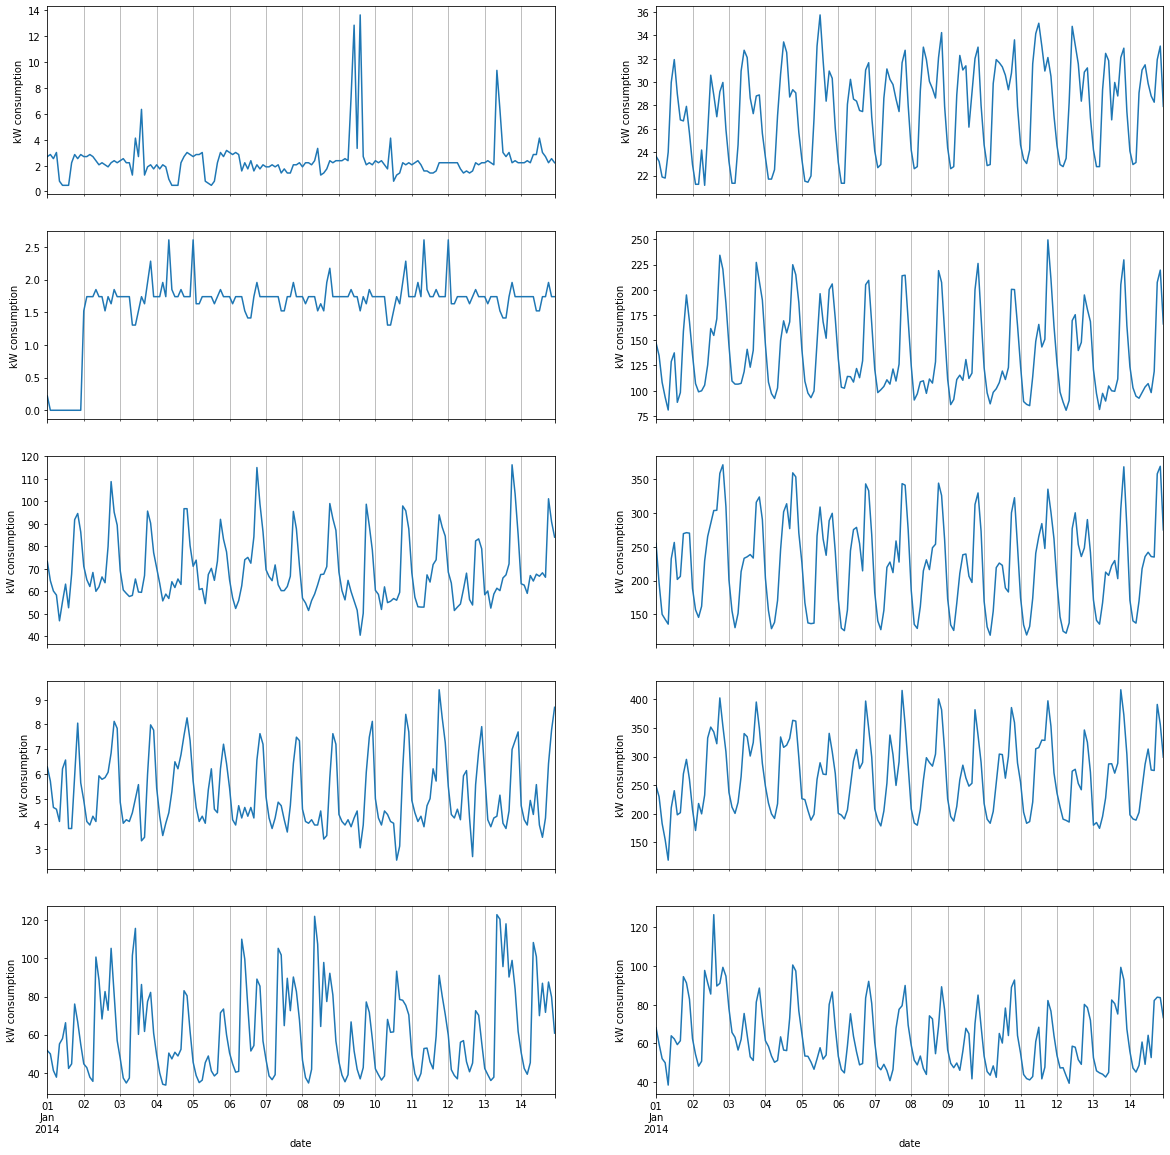

In [55]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("kW consumption")
    axx[i].grid(which="minor", axis="x")

In [56]:
# we use 2 hour frequency for the time series
freq = "2H"

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

In [57]:
start_dataset = pd.Timestamp("2014-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2014-09-01 00:00:00", freq=freq)

/tmp/ipykernel_11218/710159116.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_dataset = pd.Timestamp("2014-01-01 00:00:00", freq=freq)
/tmp/ipykernel_11218/710159116.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  end_training = pd.Timestamp("2014-09-01 00:00:00", freq=freq)


In [58]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(len(training_data))

370


In [59]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data))

1480


In [60]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [61]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 5.57 s, sys: 98.9 ms, total: 5.67 s
Wall time: 6.49 s


In [62]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [63]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-101718508260/deepar-electricity-demo-notebook/data/train/train.json
Uploading file to s3://sagemaker-us-east-1-101718508260/deepar-electricity-demo-notebook/data/test/test.json
CPU times: user 503 ms, sys: 176 ms, total: 679 ms
Wall time: 1.39 s


In [64]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2014-01-01 00:00:00", "target": [2.696700507614215, 2.85532994923858, 2.53807106598985, 3...


In [65]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-electricity-demo",
    output_path=s3_output_path,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [66]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [67]:
estimator.set_hyperparameters(**hyperparameters)

In [68]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

2022-09-18 15:52:07 Starting - Starting the training job...
2022-09-18 15:52:31 Starting - Preparing the instances for trainingProfilerReport-1663516327: InProgress
......
2022-09-18 15:53:33 Downloading - Downloading input data...
2022-09-18 15:53:51 Training - Downloading the training image......
2022-09-18 15:55:04 Training - Training image download completed. Training in progress..Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[09/18/2022 15:55:10 INFO 140407448635200] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.j

KeyboardInterrupt: 

In [69]:
from sagemaker.serializers import IdentitySerializer

In [70]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")
    
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )
    
    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj


In [71]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

KeyError: 'ModelArtifacts'

In [ ]:
predictor.predict(ts=timeseries[120], quantiles=[0.10, 0.5, 0.90]).head()

In [102]:
timeseries[120]

2014-01-14 00:00:00     88.709677
2014-01-14 02:00:00     97.062212
2014-01-14 04:00:00    104.550691
2014-01-14 06:00:00     93.029954
2014-01-14 08:00:00    153.513825
                          ...    
2014-12-31 16:00:00    342.453917
2014-12-31 18:00:00    386.232719
2014-12-31 20:00:00    330.357143
2014-12-31 22:00:00    349.654378
2015-01-01 00:00:00     39.458525
Freq: 2H, Name: MT_121, Length: 4225, dtype: float64

In [ ]:
def plot(
    predictor,
    target_ts,
    cat=None,
    dynamic_feat=None,
    forecast_date=end_training,
    show_samples=False,
    plot_history=7 * 12,
    confidence=80,
):
    freq = target_ts.index.freq
    print(
        "calling served model to generate predictions starting from {}".format(str(forecast_date))
    )
    assert confidence > 50 and confidence < 100
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5

    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100,
    }

    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1, 1, 1)

    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, "cat = {}".format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples:
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color="lightskyblue", alpha=0.2, label="_nolegend_")

    # plot the target
    target_section = target_ts[
        forecast_date - plot_history * freq : forecast_date + prediction_length * freq
    ]
    target_section.plot(color="black", label="target")


     # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index,
        prediction[str(low_quantile)].values,
        prediction[str(up_quantile)].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(confidence),
    )
    prediction["0.5"].plot(color="b", label="P50")
    ax.legend(loc=2)

    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(
                    start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)
                ),
                data=f,
            )
            feat_ts[
                forecast_date - plot_history * freq : forecast_date + prediction_length * freq
            ].plot(ax=ax, color="g")   


In [100]:
predictor.delete_endpoint(delete_endpoint_config=True)

ClientError: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:us-east-1:101718508260:endpoint-config/deepar-electricity-demo-2022-09-16-12-23-15-394".

In [98]:
predictor.delete_model()
predictor.delete_endpoint()

In [99]:
predictor_new_features.delete_model()
predictor_new_features.delete_endpoint()

NameError: name 'predictor_new_features' is not defined